## Markov structure, take 250 products

In [5]:
import AssortmentGenerator as AG
import MarkovGenerator as MG
import Models
import time

import numpy as np
import torch
import torch.nn as nn

from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

start_time = time.time()

N_prod = 250       # number of products
Vec_Len = N_prod + 1
EPOCHS = 500
SAMPLE_AMOUNT = 100000
BATCH_SIZE = 5000
TRAIN_VALI_RATE = 0.9
ADAM_LR = 0.0005

# generate latent parameters
transP = MG.GenMarkovM(
    product_num = N_prod,
    gen_func = lambda x : MG.GenTransprob_Sparse(x)
)
lams = np.random.uniform(low = 0, high = 1, size = N_prod)
lams = lams / sum(lams)

# generate synthetic data
INPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
OUTPUT = np.zeros((SAMPLE_AMOUNT,Vec_Len))
for i in range(SAMPLE_AMOUNT):
    
    # generate input vector, which has length vec_len
    # the first element is 0, which should be ignored when treated as an assortment
    assort = AG.GenAssortment_Sparse(N_prod)    
    INPUT[i] = AG.Product_0(assort)
    OUTPUT[i] = MG.Absorbing_Calculator(lams, transP, assort)

print("data generated!")
print("total time elapse : ",time.time()-start_time)

train_dataset = TensorDataset(torch.Tensor(INPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]),torch.Tensor(OUTPUT[:int(SAMPLE_AMOUNT * TRAIN_VALI_RATE)]))    
vali_dataset = TensorDataset(torch.Tensor(INPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]),torch.Tensor(OUTPUT[int(SAMPLE_AMOUNT * TRAIN_VALI_RATE):]))    

train_loader = DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
vali_loader = DataLoader(vali_dataset, shuffle=True, batch_size = len(vali_dataset))

model = Models.MarkovStructure(Vec_Len)
optimizer = optim.Adam(model.parameters(), lr = ADAM_LR)
criterion = nn.BCELoss()

training_losses = []
vali_losses = []

for epo in range(1,EPOCHS+1):
    if epo % 50 == 0:
        print("epoch : ",epo)
        print(time.time()-start_time)
    for step, (IN, TEST) in enumerate(train_loader):
        
        OUT = model(IN)
        
        loss_base = criterion(TEST,TEST).detach().item()
        loss = criterion(OUT,TEST)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_pure = loss.detach().item()
        training_losses.append((loss_pure - loss_base)/loss_base)
        
    for step, (VALI_IN, VALI_TEST) in enumerate(vali_loader):
        VALI_OUT = model(VALI_IN)
        loss = criterion(VALI_OUT,VALI_TEST)

        loss_pure = loss.detach().item()
        loss_base = criterion(VALI_TEST,VALI_TEST).detach().item()
        vali_losses.append((loss_pure - loss_base)/loss_base)

np.save('EXP4_dump/markov_matrix',transP)
np.save('EXP4_dump/arriving_lambda',lams)
np.save('EXP4_dump/MarkovStructure_train_loss', training_losses)
np.save('EXP4_dump/MarkovStructure_vali_loss', vali_losses)
torch.save(model, "EXP4_dump/MarkovStructure_model.pth")

data generated!
total time elapse :  133.23319101333618
epoch :  50
1523.4810650348663
epoch :  100
2962.1153004169464
epoch :  150
4438.559807300568
epoch :  200
5902.691653728485
epoch :  250
7355.551952600479
epoch :  300
8798.985109090805
epoch :  350
10234.5399787426
epoch :  400
11694.475864648819
epoch :  450
13081.869638442993
epoch :  500
14443.666065454483


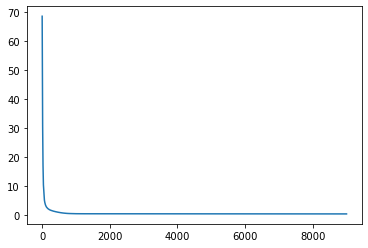

In [6]:
train_loss = np.load('EXP4_dump/MarkovStructure_train_loss.npy')
plt.plot(train_loss)

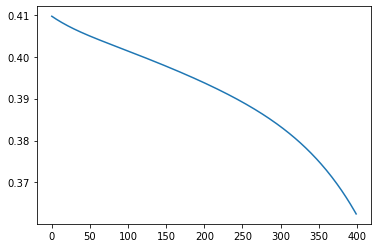

In [8]:
train_loss = np.load('EXP4_dump/MarkovStructure_vali_loss.npy')
plt.plot(train_loss[100:])